In [24]:
%pip install datasets
%pip install transformers
%pip install matplotlib
%pip install transformers[torch]

import matplotlib.pyplot as plt
import pandas as pd

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

def check_and_select_gpu():
    if torch.cuda.is_available():
        print(f"CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
        # Select the first GPU
        device = torch.device('cuda:0')
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        return device
    else:
        print("CUDA is not available. Using CPU.")
        return torch.device('cpu')

device = check_and_select_gpu()

# Example of moving a tensor to the selected device
x = torch.tensor([1.0, 2.0, 3.0])
x = x.to(device)
print(x)

CUDA is available. Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060
Using GPU: NVIDIA GeForce RTX 3060
tensor([1., 2., 3.], device='cuda:0')


In [3]:
from datasets import load_dataset
dataset = load_dataset("multi_news",trust_remote_code=True)
print(f"Features: {dataset['train'].column_names}")

c:\Users\Isadora\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Features: ['document', 'summary']


In [4]:
from datasets import load_dataset
dataset = load_dataset("multi_news")
print(f"Features: {dataset['train'].column_names}")


Features: ['document', 'summary']


In [5]:
sample = dataset["train"][1]
print(f"""Document (excerpt of 2000 characters, total length: {len(sample["document"])}):""")
print(sample["document"][:2000])
print(f'\nSummary (length: {len(sample["summary"])}):')
print(sample["summary"])

Document (excerpt of 2000 characters, total length: 5353):
LOS ANGELES (AP) — In her first interview since the NBA banned her estranged husband, Shelly Sterling says she will fight to keep her share of the Los Angeles Clippers and plans one day to divorce Donald Sterling. 
 
 (Click Prev or Next to continue viewing images.) 
 
 ADVERTISEMENT (Click Prev or Next to continue viewing images.) 
 
 Los Angeles Clippers co-owner Shelly Sterling, below, watches the Clippers play the Oklahoma City Thunder along with her attorney, Pierce O'Donnell, in the first half of Game 3 of the Western Conference... (Associated Press) 
 
 Shelly Sterling spoke to Barbara Walters, and ABC News posted a short story with excerpts from the conversation Sunday. 
 
 NBA Commissioner Adam Silver has banned Donald Sterling for making racist comments and urged owners to force Sterling to sell the team. Silver added that no decisions had been made about the rest of Sterling's family. 
 
 According to ABC's story, Sh

In [6]:
from transformers import BartForConditionalGeneration, AutoTokenizer
model_ckpt = "sshleifer/distilbart-cnn-6-6"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BartForConditionalGeneration.from_pretrained(model_ckpt)

Before we process the data for training, let us have a quick look at the length distribution of the input and outputs:

In [7]:
d_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["document"]]
s_len = [len(tokenizer.encode(s)) for s in dataset["validation"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (2331 > 1024). Running this sequence through the model will result in indexing errors


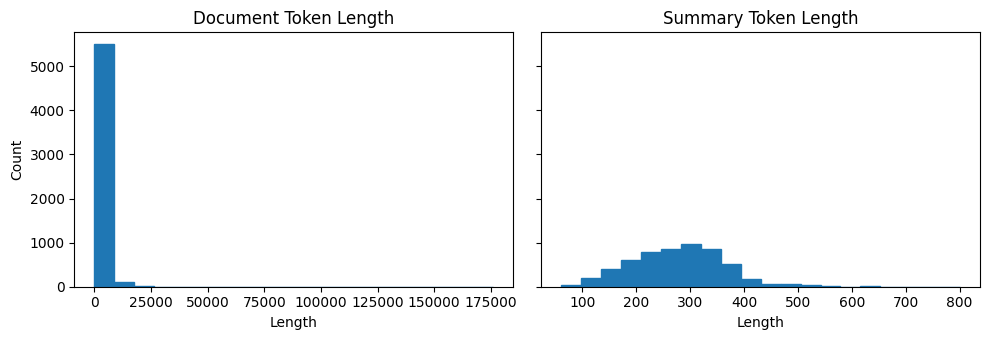

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Document Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()


Tokenize the dataset

In [9]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["document"], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=256, truncation=True)
        
    return {"input_ids": input_encodings["input_ids"], 
           "attention_mask": input_encodings["attention_mask"], 
           "labels": target_encodings["input_ids"]}
dataset_pt = dataset.map(convert_examples_to_features, batched=True)

In [10]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Training the model

In [11]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir='bart-multi-news', num_train_epochs=1, warmup_steps=500,                                  per_device_train_batch_size=1, per_device_eval_batch_size=1, weight_decay=0.01, logging_steps=10, push_to_hub=False, 
evaluation_strategy='steps', eval_steps=500, save_steps=1e6, 
gradient_accumulation_steps=16)

c:\Users\Isadora\miniconda3\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer,                  data_collator=seq2seq_data_collator,                  train_dataset=dataset_pt["train"],                  eval_dataset=dataset_pt["validation"])
trainer.train()

  0%|          | 0/2810 [00:00<?, ?it/s]c:\Users\Isadora\miniconda3\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  0%|          | 10/2810 [00:31<2:18:13,  2.96s/it]

KeyboardInterrupt: 

In [ ]:
import json
# Save the model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(training_args.output_dir)

import json

# Convert TrainingArguments to a dictionary
training_args_dict = training_args.to_dict()


# Save the dictionary to a JSON file
with open(f"{training_args.output_dir}/training_args.json", "w") as f:
    json.dump(training_args_dict, f)

# Save the trainer state
trainer.save_state()

# Save the training logs/metrics
if trainer.state.log_history:
    with open(f"{training_args.output_dir}/train_log_history.json", "w") as f:
        json.dump(trainer.state.log_history, f)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [ ]:
print(training_args_dict)

{'output_dir': 'bart-multi-news', 'overwrite_output_dir': False, 'do_train': False, 'do_eval': True, 'do_predict': False, 'eval_strategy': 'steps', 'prediction_loss_only': False, 'per_device_train_batch_size': 1, 'per_device_eval_batch_size': 1, 'per_gpu_train_batch_size': None, 'per_gpu_eval_batch_size': None, 'gradient_accumulation_steps': 16, 'eval_accumulation_steps': None, 'eval_delay': 0, 'torch_empty_cache_steps': None, 'learning_rate': 5e-05, 'weight_decay': 0.01, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'num_train_epochs': 1, 'max_steps': -1, 'lr_scheduler_type': 'linear', 'lr_scheduler_kwargs': {}, 'warmup_ratio': 0.0, 'warmup_steps': 500, 'log_level': 'passive', 'log_level_replica': 'warning', 'log_on_each_node': True, 'logging_dir': 'bart-multi-news\\runs\\Aug06_22-23-32_DESKTOP-FKK9U12', 'logging_strategy': 'steps', 'logging_first_step': False, 'logging_steps': 10, 'logging_nan_inf_filter': True, 'save_strategy': 'steps', 'save_s

In [ ]:
sample_text = dataset["test"][1]["document"]
reference = dataset["test"][1]["summary"]
print("Document:")
print(sample_text)
print("\nReference Summary:")
print(reference)

Document:

 
 
 
 UPDATE: 4/19/2001 Read Richard Metzger: How I, a married, middle-aged man, became an accidental spokesperson for gay rights overnight on Boing Boing 
 
 It’s time to clarify a few details about the controversial “Hey Facebook what’s SO wrong with a pic of two men kissing?” story, as it now beginning to be reported in the mainstream media, and not always correctly. 
 
 First of all, with regards to the picture: 
 
 The photo which was used to illustrate my first post about the John Snow Kiss-In is a promotional still from the British soap opera “Eastenders.” It features one of the main characters from the show (Christian Clarke, played by the actor John Partridge- left) and someone else who I don’t know. I am not a regular viewer so I can’t say if the man on the right is an extra or an actual character. 
 
 This picture has itself caused scandal in the UK, as it was a gay kiss that was broadcast before the watershed, and as such led to a number of complaints to the BBC

In [ ]:
input_ids = tokenizer(sample_text, max_length=1024, truncation=True, padding='max_length', return_tensors='pt').to(device)

In [ ]:
summaries = model.generate(input_ids=input_ids['input_ids'], attention_mask=input_ids['attention_mask'],                           max_length=256)

In [ ]:
decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]

In [ ]:
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries[0])


Reference Summary:
– It turns out Facebook is only guilty of about half of what it’s been accused of in the gay kiss incident. The social networking site apologized yesterday for taking down an image used to promote a “kiss-in” event in London. “The photo in question does not violate our Statement of Rights and Responsibilities, and was removed in error,” the site said in a statement, according to the Advocate. But Facebook did not, as has been reported in several places, take down the kiss-in event itself. Here’s what happened: The photo Facebook took down was posted by the Dangerous Minds blog to promote the event. In its initial write-up about the incident, the blog observed that the page organizing the protest had been taken down. But it was actually the organizer himself who "removed" the event, Dangerous Minds clarified. Organizer Paul Shetler explains that he decided to switch it from a public event to a private one, as "there were starting to be trolls posting abusive nonsense

  0%|          | 0/2810 [00:00<?, ?it/s]c:\Users\Isadora\miniconda3\Lib\site-packages\transformers\models\bart\modeling_bart.py:496: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
  0%|          | 10/2810 [00:30<2:15:56,  2.91s/it]
{'loss': 5.2546, 'grad_norm': 61.682735443115234, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
  1%|          | 20/2810 [01:00<2:18:10,  2.97s/it]
{'loss': 4.3992, 'grad_norm': 29.767976760864258, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
  1%|          | 30/2810 [01:29<2:15:51,  2.93s/it]
{'loss': 3.4408, 'grad_norm': 4.705044746398926, 'learning_rate': 3e-06, 'epoch': 0.01}
  1%|▏         | 40/2810 [01:59<2:17:45,  2.98s/it]
{'loss': 3.2893, 'grad_norm': 3.4610884189605713, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01}
  2%|▏         | 50/2810 [02:28<2:14:49,  2.93s/it]
{'loss': 3.014, 'grad_norm': 2.9409372806549072, 'learning_rate': 5e-06, 'epoch': 0.02}
  2%|▏         | 60/2810 [02:58<2:14:32,  2.94s/it]
{'loss': 2.9575, 'grad_norm': 2.5876762866973877, 'learning_rate': 6e-06, 'epoch': 0.02}
  2%|▏         | 70/2810 [03:27<2:13:26,  2.92s/it]
{'loss': 2.8834, 'grad_norm': 2.440925359725952, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.02}
  3%|▎         | 80/2810 [03:56<2:14:13,  2.95s/it]
{'loss': 2.8975, 'grad_norm': 2.312932252883911, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.03}
  3%|▎         | 90/2810 [04:27<2:15:16,  2.98s/it]
{'loss': 2.8948, 'grad_norm': 2.212564706802368, 'learning_rate': 9e-06, 'epoch': 0.03}
  4%|▎         | 100/2810 [04:56<2:13:18,  2.95s/it]
{'loss': 2.905, 'grad_norm': 2.337212562561035, 'learning_rate': 1e-05, 'epoch': 0.04}
  4%|▍         | 110/2810 [05:26<2:16:36,  3.04s/it]
{'loss': 2.7734, 'grad_norm': 2.2102715969085693, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.04}
  4%|▍         | 120/2810 [05:57<2:15:43,  3.03s/it]
{'loss': 2.8855, 'grad_norm': 2.2873475551605225, 'learning_rate': 1.2e-05, 'epoch': 0.04}
  5%|▍         | 130/2810 [06:26<2:09:41,  2.90s/it]
{'loss': 2.8858, 'grad_norm': 2.305936336517334, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.05}
  5%|▍         | 140/2810 [06:55<2:11:39,  2.96s/it]
{'loss': 2.7837, 'grad_norm': 2.2331066131591797, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.05}
  5%|▌         | 150/2810 [07:25<2:10:07,  2.94s/it]
{'loss': 2.8238, 'grad_norm': 2.3905320167541504, 'learning_rate': 1.5e-05, 'epoch': 0.05}
  6%|▌         | 160/2810 [07:55<2:11:52,  2.99s/it]
{'loss': 2.7815, 'grad_norm': 2.1723387241363525, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.06}
  6%|▌         | 170/2810 [08:24<2:11:29,  2.99s/it]
{'loss': 2.7365, 'grad_norm': 2.123204231262207, 'learning_rate': 1.7000000000000003e-05, 'epoch': 0.06}
  6%|▋         | 180/2810 [08:54<2:07:59,  2.92s/it]
{'loss': 2.7814, 'grad_norm': 2.1975979804992676, 'learning_rate': 1.8e-05, 'epoch': 0.06}
  7%|▋         | 190/2810 [09:23<2:07:46,  2.93s/it]
{'loss': 2.8178, 'grad_norm': 2.249804973602295, 'learning_rate': 1.9e-05, 'epoch': 0.07}
  7%|▋         | 200/2810 [09:53<2:10:00,  2.99s/it]
{'loss': 2.7738, 'grad_norm': 2.211214065551758, 'learning_rate': 2e-05, 'epoch': 0.07}
  7%|▋         | 210/2810 [10:22<2:06:35,  2.92s/it]
{'loss': 2.8148, 'grad_norm': 2.3486504554748535, 'learning_rate': 2.1e-05, 'epoch': 0.07}
  8%|▊         | 220/2810 [10:52<2:09:59,  3.01s/it]
{'loss': 2.8068, 'grad_norm': 2.1448123455047607, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.08}
  8%|▊         | 230/2810 [11:22<2:06:12,  2.93s/it]
{'loss': 2.716, 'grad_norm': 2.267228841781616, 'learning_rate': 2.3000000000000003e-05, 'epoch': 0.08}
  9%|▊         | 240/2810 [11:52<2:07:25,  2.97s/it]
{'loss': 2.7366, 'grad_norm': 2.204408645629883, 'learning_rate': 2.4e-05, 'epoch': 0.09}
  9%|▉         | 250/2810 [12:21<2:07:22,  2.99s/it]
{'loss': 2.8342, 'grad_norm': 2.232079029083252, 'learning_rate': 2.5e-05, 'epoch': 0.09}
  9%|▉         | 260/2810 [12:51<2:04:43,  2.93s/it]
{'loss': 2.6771, 'grad_norm': 2.3118278980255127, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.09}
 10%|▉         | 270/2810 [13:21<2:07:31,  3.01s/it]
{'loss': 2.9005, 'grad_norm': 2.293320417404175, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.1}
 10%|▉         | 280/2810 [13:50<2:02:13,  2.90s/it]
{'loss': 2.7719, 'grad_norm': 2.2063870429992676, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.1}
 10%|█         | 290/2810 [14:20<2:04:45,  2.97s/it]
{'loss': 2.6869, 'grad_norm': 2.336620330810547, 'learning_rate': 2.9e-05, 'epoch': 0.1}
 11%|█         | 300/2810 [14:49<2:04:03,  2.97s/it]
{'loss': 2.6939, 'grad_norm': 2.1450154781341553, 'learning_rate': 3e-05, 'epoch': 0.11}
 11%|█         | 310/2810 [15:20<2:06:08,  3.03s/it]
{'loss': 2.6279, 'grad_norm': 2.048473358154297, 'learning_rate': 3.1e-05, 'epoch': 0.11}
 11%|█▏        | 320/2810 [15:49<2:02:17,  2.95s/it]
{'loss': 2.7236, 'grad_norm': 2.161191701889038, 'learning_rate': 3.2000000000000005e-05, 'epoch': 0.11}
 12%|█▏        | 330/2810 [16:17<2:00:00,  2.90s/it]
{'loss': 2.6846, 'grad_norm': 2.0124447345733643, 'learning_rate': 3.3e-05, 'epoch': 0.12}
 12%|█▏        | 340/2810 [16:46<1:56:54,  2.84s/it]
{'loss': 2.7036, 'grad_norm': 2.1550679206848145, 'learning_rate': 3.4000000000000007e-05, 'epoch': 0.12}
 12%|█▏        | 350/2810 [17:14<1:57:27,  2.87s/it]
{'loss': 2.7116, 'grad_norm': 2.086399793624878, 'learning_rate': 3.5e-05, 'epoch': 0.12}
 13%|█▎        | 360/2810 [17:43<1:56:40,  2.86s/it]
{'loss': 2.7409, 'grad_norm': 2.215425491333008, 'learning_rate': 3.6e-05, 'epoch': 0.13}
 13%|█▎        | 370/2810 [18:12<1:57:24,  2.89s/it]
{'loss': 2.6613, 'grad_norm': 2.0666635036468506, 'learning_rate': 3.7e-05, 'epoch': 0.13}
 14%|█▎        | 380/2810 [18:40<1:56:46,  2.88s/it]
{'loss': 2.793, 'grad_norm': 2.082519769668579, 'learning_rate': 3.8e-05, 'epoch': 0.14}
 14%|█▍        | 390/2810 [19:09<1:57:34,  2.92s/it]
{'loss': 2.6661, 'grad_norm': 2.218961000442505, 'learning_rate': 3.9000000000000006e-05, 'epoch': 0.14}
 14%|█▍        | 400/2810 [19:37<1:56:01,  2.89s/it]
{'loss': 2.7249, 'grad_norm': 2.2179386615753174, 'learning_rate': 4e-05, 'epoch': 0.14}
 15%|█▍        | 410/2810 [20:06<1:54:35,  2.86s/it]
{'loss': 2.6289, 'grad_norm': 2.1682493686676025, 'learning_rate': 4.1e-05, 'epoch': 0.15}
 15%|█▍        | 420/2810 [20:35<1:56:10,  2.92s/it]
{'loss': 2.6995, 'grad_norm': 2.075914144515991, 'learning_rate': 4.2e-05, 'epoch': 0.15}
 15%|█▌        | 430/2810 [21:03<1:49:58,  2.77s/it]
{'loss': 2.6078, 'grad_norm': 2.1976966857910156, 'learning_rate': 4.3e-05, 'epoch': 0.15}
 16%|█▌        | 440/2810 [21:31<1:50:51,  2.81s/it]
{'loss': 2.6156, 'grad_norm': 2.066948890686035, 'learning_rate': 4.4000000000000006e-05, 'epoch': 0.16}
 16%|█▌        | 450/2810 [22:00<1:51:57,  2.85s/it]
{'loss': 2.6982, 'grad_norm': 2.00141978263855, 'learning_rate': 4.5e-05, 'epoch': 0.16}
 16%|█▋        | 460/2810 [22:29<1:52:30,  2.87s/it]
{'loss': 2.7775, 'grad_norm': 2.094660758972168, 'learning_rate': 4.600000000000001e-05, 'epoch': 0.16}
 17%|█▋        | 470/2810 [22:57<1:51:21,  2.86s/it]
{'loss': 2.695, 'grad_norm': 2.253774404525757, 'learning_rate': 4.7e-05, 'epoch': 0.17}
 17%|█▋        | 480/2810 [23:27<1:54:40,  2.95s/it]
{'loss': 2.7213, 'grad_norm': 2.1683733463287354, 'learning_rate': 4.8e-05, 'epoch': 0.17}
 17%|█▋        | 490/2810 [23:55<1:49:23,  2.83s/it]
{'loss': 2.5926, 'grad_norm': 2.0965378284454346, 'learning_rate': 4.9e-05, 'epoch': 0.17}
 18%|█▊        | 500/2810 [24:24<1:53:02,  2.94s/it]
{'loss': 2.7435, 'grad_norm': 2.2442538738250732, 'learning_rate': 5e-05, 'epoch': 0.18}
                                                    
 18%|█▊        | 500/2810 [29:21<1:53:02,  2.94s/it]
{'eval_loss': 2.5658278465270996, 'eval_runtime': 296.4752, 'eval_samples_per_second': 18.963, 'eval_steps_per_second': 18.963, 'epoch': 0.18}
 18%|█▊        | 510/2810 [29:50<4:10:04,  6.52s/it] 
{'loss': 2.7058, 'grad_norm': 2.018270969390869, 'learning_rate': 4.978354978354979e-05, 'epoch': 0.18}
 19%|█▊        | 520/2810 [30:18<1:52:12,  2.94s/it]
{'loss': 2.6302, 'grad_norm': 2.12916898727417, 'learning_rate': 4.956709956709957e-05, 'epoch': 0.19}
 19%|█▉        | 530/2810 [30:47<1:51:00,  2.92s/it]
{'loss': 2.6189, 'grad_norm': 2.024284601211548, 'learning_rate': 4.9350649350649355e-05, 'epoch': 0.19}
 19%|█▉        | 540/2810 [31:15<1:45:50,  2.80s/it]
{'loss': 2.6519, 'grad_norm': 1.9710406064987183, 'learning_rate': 4.9134199134199135e-05, 'epoch': 0.19}
 20%|█▉        | 550/2810 [31:44<1:51:27,  2.96s/it]
{'loss': 2.6225, 'grad_norm': 2.0850610733032227, 'learning_rate': 4.8917748917748915e-05, 'epoch': 0.2}
 20%|█▉        | 560/2810 [32:13<1:45:56,  2.83s/it]
{'loss': 2.6967, 'grad_norm': 2.3823704719543457, 'learning_rate': 4.87012987012987e-05, 'epoch': 0.2}
 20%|██        | 570/2810 [32:41<1:46:06,  2.84s/it]
{'loss': 2.6473, 'grad_norm': 2.0779922008514404, 'learning_rate': 4.848484848484849e-05, 'epoch': 0.2}
 21%|██        | 580/2810 [33:10<1:44:57,  2.82s/it]
{'loss': 2.6135, 'grad_norm': 2.079591751098633, 'learning_rate': 4.826839826839827e-05, 'epoch': 0.21}
 21%|██        | 590/2810 [33:39<1:45:33,  2.85s/it]
{'loss': 2.6675, 'grad_norm': 2.1378095149993896, 'learning_rate': 4.8051948051948054e-05, 'epoch': 0.21}
 21%|██▏       | 600/2810 [34:07<1:44:04,  2.83s/it]
{'loss': 2.596, 'grad_norm': 2.112705945968628, 'learning_rate': 4.783549783549784e-05, 'epoch': 0.21}
 22%|██▏       | 610/2810 [34:36<1:44:37,  2.85s/it]
{'loss': 2.6522, 'grad_norm': 2.1592161655426025, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.22}
 22%|██▏       | 620/2810 [35:04<1:42:39,  2.81s/it]
{'loss': 2.601, 'grad_norm': 2.006589889526367, 'learning_rate': 4.740259740259741e-05, 'epoch': 0.22}
 22%|██▏       | 630/2810 [35:33<1:42:22,  2.82s/it]
{'loss': 2.7173, 'grad_norm': 2.065869092941284, 'learning_rate': 4.718614718614719e-05, 'epoch': 0.22}
 23%|██▎       | 640/2810 [36:01<1:43:19,  2.86s/it]
{'loss': 2.5092, 'grad_norm': 1.9556689262390137, 'learning_rate': 4.696969696969697e-05, 'epoch': 0.23}
 23%|██▎       | 650/2810 [36:30<1:41:54,  2.83s/it]
{'loss': 2.6241, 'grad_norm': 2.1354570388793945, 'learning_rate': 4.675324675324675e-05, 'epoch': 0.23}
 23%|██▎       | 660/2810 [36:59<1:43:51,  2.90s/it]
{'loss': 2.5977, 'grad_norm': 2.053691864013672, 'learning_rate': 4.653679653679654e-05, 'epoch': 0.23}
 24%|██▍       | 670/2810 [37:27<1:40:36,  2.82s/it]
{'loss': 2.5934, 'grad_norm': 2.277036666870117, 'learning_rate': 4.6320346320346326e-05, 'epoch': 0.24}
 24%|██▍       | 680/2810 [37:55<1:42:43,  2.89s/it]
{'loss': 2.6297, 'grad_norm': 2.1197218894958496, 'learning_rate': 4.6103896103896106e-05, 'epoch': 0.24}
 25%|██▍       | 690/2810 [38:24<1:40:13,  2.84s/it]
{'loss': 2.5449, 'grad_norm': 2.0263333320617676, 'learning_rate': 4.588744588744589e-05, 'epoch': 0.25}
 25%|██▍       | 700/2810 [38:52<1:39:44,  2.84s/it]
{'loss': 2.6921, 'grad_norm': 2.0305252075195312, 'learning_rate': 4.567099567099568e-05, 'epoch': 0.25}
 25%|██▌       | 710/2810 [39:22<1:42:00,  2.91s/it]
{'loss': 2.6184, 'grad_norm': 1.9867206811904907, 'learning_rate': 4.545454545454546e-05, 'epoch': 0.25}
 26%|██▌       | 720/2810 [39:51<1:41:26,  2.91s/it]
{'loss': 2.6548, 'grad_norm': 2.0836615562438965, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.26}
 26%|██▌       | 730/2810 [40:20<1:38:57,  2.85s/it]
{'loss': 2.6467, 'grad_norm': 2.172215700149536, 'learning_rate': 4.5021645021645025e-05, 'epoch': 0.26}
 26%|██▋       | 740/2810 [40:49<1:38:08,  2.84s/it]
{'loss': 2.5021, 'grad_norm': 2.082801580429077, 'learning_rate': 4.4805194805194805e-05, 'epoch': 0.26}
 27%|██▋       | 750/2810 [41:17<1:36:27,  2.81s/it]
{'loss': 2.55, 'grad_norm': 1.9966254234313965, 'learning_rate': 4.458874458874459e-05, 'epoch': 0.27}
 27%|██▋       | 760/2810 [41:46<1:39:00,  2.90s/it]
{'loss': 2.5996, 'grad_norm': 1.9188635349273682, 'learning_rate': 4.437229437229438e-05, 'epoch': 0.27}
 27%|██▋       | 770/2810 [42:15<1:37:03,  2.85s/it]
{'loss': 2.5762, 'grad_norm': 2.044360876083374, 'learning_rate': 4.415584415584416e-05, 'epoch': 0.27}
 28%|██▊       | 780/2810 [42:43<1:34:25,  2.79s/it]
{'loss': 2.5228, 'grad_norm': 2.2422263622283936, 'learning_rate': 4.3939393939393944e-05, 'epoch': 0.28}
 28%|██▊       | 790/2810 [43:12<1:37:22,  2.89s/it]
{'loss': 2.6083, 'grad_norm': 2.0195162296295166, 'learning_rate': 4.3722943722943724e-05, 'epoch': 0.28}
 28%|██▊       | 800/2810 [43:41<1:37:26,  2.91s/it]
{'loss': 2.6721, 'grad_norm': 2.036341428756714, 'learning_rate': 4.3506493506493503e-05, 'epoch': 0.28}
 29%|██▉       | 810/2810 [44:10<1:37:20,  2.92s/it]
{'loss': 2.6086, 'grad_norm': 1.9771127700805664, 'learning_rate': 4.329004329004329e-05, 'epoch': 0.29}
 29%|██▉       | 820/2810 [44:39<1:35:47,  2.89s/it]
{'loss': 2.5066, 'grad_norm': 2.162167549133301, 'learning_rate': 4.3073593073593077e-05, 'epoch': 0.29}
 30%|██▉       | 830/2810 [45:07<1:32:23,  2.80s/it]
{'loss': 2.6107, 'grad_norm': 2.4231810569763184, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.3}
 30%|██▉       | 840/2810 [45:36<1:35:37,  2.91s/it]
{'loss': 2.6031, 'grad_norm': 2.0049538612365723, 'learning_rate': 4.264069264069264e-05, 'epoch': 0.3}
 30%|███       | 850/2810 [46:05<1:34:00,  2.88s/it]
{'loss': 2.6103, 'grad_norm': 2.041731357574463, 'learning_rate': 4.242424242424243e-05, 'epoch': 0.3}
 31%|███       | 860/2810 [46:34<1:33:18,  2.87s/it]
{'loss': 2.6535, 'grad_norm': 2.1706438064575195, 'learning_rate': 4.220779220779221e-05, 'epoch': 0.31}
 31%|███       | 870/2810 [47:02<1:29:44,  2.78s/it]
{'loss': 2.5893, 'grad_norm': 2.192211389541626, 'learning_rate': 4.1991341991341996e-05, 'epoch': 0.31}
 31%|███▏      | 880/2810 [47:31<1:31:43,  2.85s/it]
{'loss': 2.5435, 'grad_norm': 2.070277214050293, 'learning_rate': 4.1774891774891775e-05, 'epoch': 0.31}
 32%|███▏      | 890/2810 [48:00<1:30:26,  2.83s/it]
{'loss': 2.5387, 'grad_norm': 2.03592586517334, 'learning_rate': 4.155844155844156e-05, 'epoch': 0.32}
 32%|███▏      | 900/2810 [48:28<1:30:10,  2.83s/it]
{'loss': 2.5546, 'grad_norm': 1.964775562286377, 'learning_rate': 4.134199134199134e-05, 'epoch': 0.32}
 32%|███▏      | 910/2810 [48:56<1:28:41,  2.80s/it]
{'loss': 2.6434, 'grad_norm': 2.046565532684326, 'learning_rate': 4.112554112554113e-05, 'epoch': 0.32}
 33%|███▎      | 920/2810 [49:24<1:28:14,  2.80s/it]
{'loss': 2.6067, 'grad_norm': 2.1645398139953613, 'learning_rate': 4.0909090909090915e-05, 'epoch': 0.33}
 33%|███▎      | 930/2810 [49:53<1:31:08,  2.91s/it]
{'loss': 2.6499, 'grad_norm': 1.9324345588684082, 'learning_rate': 4.0692640692640695e-05, 'epoch': 0.33}
 33%|███▎      | 940/2810 [50:21<1:29:58,  2.89s/it]
{'loss': 2.5535, 'grad_norm': 2.1782326698303223, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.33}
 34%|███▍      | 950/2810 [50:50<1:29:48,  2.90s/it]
{'loss': 2.638, 'grad_norm': 1.9397279024124146, 'learning_rate': 4.025974025974026e-05, 'epoch': 0.34}
 34%|███▍      | 960/2810 [51:18<1:26:33,  2.81s/it]
{'loss': 2.6142, 'grad_norm': 1.8959428071975708, 'learning_rate': 4.004329004329004e-05, 'epoch': 0.34}
 35%|███▍      | 970/2810 [51:46<1:27:15,  2.85s/it]
{'loss': 2.6487, 'grad_norm': 2.1592936515808105, 'learning_rate': 3.982683982683983e-05, 'epoch': 0.35}
 35%|███▍      | 980/2810 [52:15<1:26:04,  2.82s/it]
{'loss': 2.5913, 'grad_norm': 2.366725206375122, 'learning_rate': 3.9610389610389614e-05, 'epoch': 0.35}
 35%|███▌      | 990/2810 [52:44<1:27:18,  2.88s/it]
{'loss': 2.5376, 'grad_norm': 2.041219472885132, 'learning_rate': 3.939393939393939e-05, 'epoch': 0.35}
 36%|███▌      | 1000/2810 [53:13<1:26:08,  2.86s/it]
{'loss': 2.6357, 'grad_norm': 2.0202198028564453, 'learning_rate': 3.917748917748918e-05, 'epoch': 0.36}
                                                     
 36%|███▌      | 1000/2810 [1:04:01<1:26:08,  2.86s/it]
{'eval_loss': 2.4882185459136963, 'eval_runtime': 647.8249, 'eval_samples_per_second': 8.678, 'eval_steps_per_second': 8.678, 'epoch': 0.36}
 36%|███▌      | 1010/2810 [1:04:29<5:18:58, 10.63s/it]  
{'loss': 2.5592, 'grad_norm': 2.0583109855651855, 'learning_rate': 3.8961038961038966e-05, 'epoch': 0.36}
 36%|███▋      | 1020/2810 [1:04:57<1:31:04,  3.05s/it]
{'loss': 2.5014, 'grad_norm': 1.9900206327438354, 'learning_rate': 3.8744588744588746e-05, 'epoch': 0.36}
 37%|███▋      | 1030/2810 [1:05:26<1:23:13,  2.81s/it]
{'loss': 2.622, 'grad_norm': 2.188924551010132, 'learning_rate': 3.852813852813853e-05, 'epoch': 0.37}
 37%|███▋      | 1040/2810 [1:05:54<1:23:27,  2.83s/it]
{'loss': 2.5404, 'grad_norm': 2.1115453243255615, 'learning_rate': 3.831168831168831e-05, 'epoch': 0.37}
 37%|███▋      | 1050/2810 [1:06:23<1:24:52,  2.89s/it]
{'loss': 2.6272, 'grad_norm': 1.9510095119476318, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.37}
 38%|███▊      | 1060/2810 [1:06:52<1:22:14,  2.82s/it]
{'loss': 2.5432, 'grad_norm': 2.146303176879883, 'learning_rate': 3.787878787878788e-05, 'epoch': 0.38}
 38%|███▊      | 1070/2810 [1:07:20<1:21:29,  2.81s/it]
{'loss': 2.5532, 'grad_norm': 2.0310347080230713, 'learning_rate': 3.7662337662337665e-05, 'epoch': 0.38}
 38%|███▊      | 1080/2810 [1:07:49<1:23:03,  2.88s/it]
{'loss': 2.6071, 'grad_norm': 1.954820156097412, 'learning_rate': 3.7445887445887445e-05, 'epoch': 0.38}
 39%|███▉      | 1090/2810 [1:08:18<1:23:12,  2.90s/it]
{'loss': 2.5194, 'grad_norm': 1.8913493156433105, 'learning_rate': 3.722943722943723e-05, 'epoch': 0.39}
 39%|███▉      | 1100/2810 [1:08:47<1:23:21,  2.93s/it]
{'loss': 2.5224, 'grad_norm': 2.057129383087158, 'learning_rate': 3.701298701298702e-05, 'epoch': 0.39}
 40%|███▉      | 1110/2810 [1:09:16<1:21:15,  2.87s/it]
{'loss': 2.618, 'grad_norm': 2.2945189476013184, 'learning_rate': 3.67965367965368e-05, 'epoch': 0.39}
 40%|███▉      | 1120/2810 [1:09:44<1:20:55,  2.87s/it]
{'loss': 2.5684, 'grad_norm': 2.0396034717559814, 'learning_rate': 3.6580086580086584e-05, 'epoch': 0.4}
 40%|████      | 1130/2810 [1:10:13<1:20:23,  2.87s/it]
{'loss': 2.5382, 'grad_norm': 1.9729381799697876, 'learning_rate': 3.6363636363636364e-05, 'epoch': 0.4}
 41%|████      | 1140/2810 [1:10:42<1:21:11,  2.92s/it]
{'loss': 2.6448, 'grad_norm': 1.9865950345993042, 'learning_rate': 3.6147186147186144e-05, 'epoch': 0.41}
 41%|████      | 1150/2810 [1:11:11<1:19:03,  2.86s/it]
{'loss': 2.531, 'grad_norm': 2.033966302871704, 'learning_rate': 3.593073593073593e-05, 'epoch': 0.41}
 41%|████▏     | 1160/2810 [1:11:39<1:16:56,  2.80s/it]
{'loss': 2.5549, 'grad_norm': 1.858897089958191, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.41}
 42%|████▏     | 1170/2810 [1:12:08<1:18:30,  2.87s/it]
{'loss': 2.5222, 'grad_norm': 2.0682506561279297, 'learning_rate': 3.5497835497835503e-05, 'epoch': 0.42}
 42%|████▏     | 1180/2810 [1:12:36<1:16:41,  2.82s/it]
{'loss': 2.5712, 'grad_norm': 1.8875776529312134, 'learning_rate': 3.528138528138528e-05, 'epoch': 0.42}
 42%|████▏     | 1190/2810 [1:13:04<1:15:56,  2.81s/it]
{'loss': 2.5573, 'grad_norm': 2.0910794734954834, 'learning_rate': 3.506493506493507e-05, 'epoch': 0.42}
 43%|████▎     | 1200/2810 [1:13:33<1:18:00,  2.91s/it]
{'loss': 2.4736, 'grad_norm': 2.0388081073760986, 'learning_rate': 3.484848484848485e-05, 'epoch': 0.43}
 43%|████▎     | 1210/2810 [1:14:01<1:15:59,  2.85s/it]
{'loss': 2.6518, 'grad_norm': 2.02561354637146, 'learning_rate': 3.463203463203463e-05, 'epoch': 0.43}
 43%|████▎     | 1220/2810 [1:14:30<1:17:03,  2.91s/it]
{'loss': 2.6102, 'grad_norm': 2.1516830921173096, 'learning_rate': 3.4415584415584416e-05, 'epoch': 0.43}
 44%|████▍     | 1230/2810 [1:14:59<1:15:15,  2.86s/it]
{'loss': 2.643, 'grad_norm': 2.072599411010742, 'learning_rate': 3.41991341991342e-05, 'epoch': 0.44}
 44%|████▍     | 1240/2810 [1:15:26<1:12:18,  2.76s/it]
{'loss': 2.5397, 'grad_norm': 2.196908712387085, 'learning_rate': 3.398268398268398e-05, 'epoch': 0.44}
 44%|████▍     | 1250/2810 [1:15:55<1:15:29,  2.90s/it]
{'loss': 2.5402, 'grad_norm': 1.9446536302566528, 'learning_rate': 3.376623376623377e-05, 'epoch': 0.44}
 45%|████▍     | 1260/2810 [1:16:24<1:13:26,  2.84s/it]
{'loss': 2.5621, 'grad_norm': 2.1874430179595947, 'learning_rate': 3.3549783549783555e-05, 'epoch': 0.45}
 45%|████▌     | 1270/2810 [1:16:53<1:13:58,  2.88s/it]
{'loss': 2.55, 'grad_norm': 1.9732416868209839, 'learning_rate': 3.3333333333333335e-05, 'epoch': 0.45}
 46%|████▌     | 1280/2810 [1:17:21<1:12:22,  2.84s/it]
{'loss': 2.5556, 'grad_norm': 1.9861937761306763, 'learning_rate': 3.311688311688312e-05, 'epoch': 0.46}
 46%|████▌     | 1290/2810 [1:17:50<1:12:40,  2.87s/it]
{'loss': 2.551, 'grad_norm': 1.9045606851577759, 'learning_rate': 3.29004329004329e-05, 'epoch': 0.46}
 46%|████▋     | 1300/2810 [1:18:52<1:23:48,  3.33s/it]
{'loss': 2.5645, 'grad_norm': 2.0619096755981445, 'learning_rate': 3.268398268398268e-05, 'epoch': 0.46}
 47%|████▋     | 1310/2810 [1:19:20<1:10:30,  2.82s/it]
{'loss': 2.5733, 'grad_norm': 2.0291452407836914, 'learning_rate': 3.246753246753247e-05, 'epoch': 0.47}
 47%|████▋     | 1320/2810 [1:19:49<1:10:38,  2.84s/it]
{'loss': 2.6258, 'grad_norm': 1.923256516456604, 'learning_rate': 3.2251082251082254e-05, 'epoch': 0.47}
 47%|████▋     | 1330/2810 [1:20:17<1:11:08,  2.88s/it]
{'loss': 2.6504, 'grad_norm': 2.0589096546173096, 'learning_rate': 3.2034632034632034e-05, 'epoch': 0.47}
 48%|████▊     | 1340/2810 [1:20:46<1:09:23,  2.83s/it]
{'loss': 2.5366, 'grad_norm': 2.051905870437622, 'learning_rate': 3.181818181818182e-05, 'epoch': 0.48}
 48%|████▊     | 1350/2810 [1:21:15<1:10:58,  2.92s/it]
{'loss': 2.5282, 'grad_norm': 2.054396152496338, 'learning_rate': 3.160173160173161e-05, 'epoch': 0.48}
 48%|████▊     | 1360/2810 [1:21:44<1:08:29,  2.83s/it]
{'loss': 2.5993, 'grad_norm': 1.897360920906067, 'learning_rate': 3.1385281385281387e-05, 'epoch': 0.48}
 49%|████▉     | 1370/2810 [1:22:12<1:08:39,  2.86s/it]
{'loss': 2.4269, 'grad_norm': 2.050745725631714, 'learning_rate': 3.1168831168831166e-05, 'epoch': 0.49}
 49%|████▉     | 1380/2810 [1:22:41<1:07:36,  2.84s/it]
{'loss': 2.5466, 'grad_norm': 2.2385571002960205, 'learning_rate': 3.095238095238095e-05, 'epoch': 0.49}
 49%|████▉     | 1390/2810 [1:23:10<1:08:47,  2.91s/it]
{'loss': 2.4857, 'grad_norm': 1.9205838441848755, 'learning_rate': 3.073593073593073e-05, 'epoch': 0.49}
 50%|████▉     | 1400/2810 [1:23:39<1:07:58,  2.89s/it]
{'loss': 2.5643, 'grad_norm': 2.1647629737854004, 'learning_rate': 3.051948051948052e-05, 'epoch': 0.5}
 50%|█████     | 1410/2810 [1:24:07<1:06:15,  2.84s/it]
{'loss': 2.4964, 'grad_norm': 2.117114543914795, 'learning_rate': 3.0303030303030306e-05, 'epoch': 0.5}
 51%|█████     | 1420/2810 [1:24:36<1:05:18,  2.82s/it]
{'loss': 2.5822, 'grad_norm': 2.0430185794830322, 'learning_rate': 3.0086580086580092e-05, 'epoch': 0.51}
 51%|█████     | 1430/2810 [1:25:04<1:06:10,  2.88s/it]
{'loss': 2.5623, 'grad_norm': 1.8989166021347046, 'learning_rate': 2.9870129870129872e-05, 'epoch': 0.51}
 51%|█████     | 1440/2810 [1:25:33<1:03:48,  2.79s/it]
{'loss': 2.4954, 'grad_norm': 2.009791374206543, 'learning_rate': 2.9653679653679655e-05, 'epoch': 0.51}
 52%|█████▏    | 1450/2810 [1:26:01<1:04:56,  2.87s/it]
{'loss': 2.4342, 'grad_norm': 1.9882845878601074, 'learning_rate': 2.943722943722944e-05, 'epoch': 0.52}
 52%|█████▏    | 1460/2810 [1:26:29<1:03:08,  2.81s/it]
{'loss': 2.4919, 'grad_norm': 2.069504499435425, 'learning_rate': 2.922077922077922e-05, 'epoch': 0.52}
 52%|█████▏    | 1470/2810 [1:26:58<1:04:57,  2.91s/it]
{'loss': 2.5837, 'grad_norm': 1.95231294631958, 'learning_rate': 2.9004329004329005e-05, 'epoch': 0.52}
 53%|█████▎    | 1480/2810 [1:27:26<1:01:54,  2.79s/it]
{'loss': 2.453, 'grad_norm': 2.087599515914917, 'learning_rate': 2.878787878787879e-05, 'epoch': 0.53}
 53%|█████▎    | 1490/2810 [1:27:55<1:04:55,  2.95s/it]
{'loss': 2.5683, 'grad_norm': 1.8179371356964111, 'learning_rate': 2.857142857142857e-05, 'epoch': 0.53}
 53%|█████▎    | 1500/2810 [1:28:24<1:02:22,  2.86s/it]
{'loss': 2.5033, 'grad_norm': 2.0245730876922607, 'learning_rate': 2.8354978354978357e-05, 'epoch': 0.53}
                                                       
 53%|█████▎    | 1500/2810 [1:33:21<1:02:22,  2.86s/it]
{'eval_loss': 2.4388561248779297, 'eval_runtime': 297.0758, 'eval_samples_per_second': 18.924, 'eval_steps_per_second': 18.924, 'epoch': 0.53}
 54%|█████▎    | 1510/2810 [1:33:50<2:20:43,  6.49s/it] 
{'loss': 2.4982, 'grad_norm': 2.0487003326416016, 'learning_rate': 2.813852813852814e-05, 'epoch': 0.54}
 54%|█████▍    | 1520/2810 [1:34:19<1:05:11,  3.03s/it]
{'loss': 2.5341, 'grad_norm': 2.054612874984741, 'learning_rate': 2.792207792207792e-05, 'epoch': 0.54}
 54%|█████▍    | 1530/2810 [1:34:49<1:03:02,  2.96s/it]
{'loss': 2.5907, 'grad_norm': 2.0309247970581055, 'learning_rate': 2.7705627705627707e-05, 'epoch': 0.54}
 55%|█████▍    | 1540/2810 [1:35:17<1:00:07,  2.84s/it]
{'loss': 2.5544, 'grad_norm': 1.9603549242019653, 'learning_rate': 2.7489177489177493e-05, 'epoch': 0.55}
 55%|█████▌    | 1550/2810 [1:35:46<1:02:00,  2.95s/it]
{'loss': 2.5177, 'grad_norm': 1.9735013246536255, 'learning_rate': 2.7272727272727273e-05, 'epoch': 0.55}
 56%|█████▌    | 1560/2810 [1:36:15<59:56,  2.88s/it]  
{'loss': 2.5603, 'grad_norm': 1.9738671779632568, 'learning_rate': 2.7056277056277056e-05, 'epoch': 0.56}
 56%|█████▌    | 1570/2810 [1:36:44<57:16,  2.77s/it]  
{'loss': 2.503, 'grad_norm': 2.0297598838806152, 'learning_rate': 2.6839826839826843e-05, 'epoch': 0.56}
 56%|█████▌    | 1580/2810 [1:37:12<58:28,  2.85s/it]
{'loss': 2.5676, 'grad_norm': 2.110194683074951, 'learning_rate': 2.6623376623376623e-05, 'epoch': 0.56}
 57%|█████▋    | 1590/2810 [1:37:40<57:30,  2.83s/it]
{'loss': 2.499, 'grad_norm': 1.8669440746307373, 'learning_rate': 2.640692640692641e-05, 'epoch': 0.57}
 57%|█████▋    | 1600/2810 [1:38:09<58:11,  2.89s/it]
{'loss': 2.5406, 'grad_norm': 1.9634442329406738, 'learning_rate': 2.6190476190476192e-05, 'epoch': 0.57}
 57%|█████▋    | 1610/2810 [1:38:38<58:12,  2.91s/it]
{'loss': 2.5588, 'grad_norm': 1.918675422668457, 'learning_rate': 2.5974025974025972e-05, 'epoch': 0.57}
 58%|█████▊    | 1620/2810 [1:39:06<56:34,  2.85s/it]
{'loss': 2.4901, 'grad_norm': 2.0811893939971924, 'learning_rate': 2.575757575757576e-05, 'epoch': 0.58}
 58%|█████▊    | 1630/2810 [1:39:35<55:33,  2.82s/it]
{'loss': 2.502, 'grad_norm': 2.101987600326538, 'learning_rate': 2.5541125541125545e-05, 'epoch': 0.58}
 58%|█████▊    | 1640/2810 [1:40:03<56:05,  2.88s/it]
{'loss': 2.4644, 'grad_norm': 1.9444208145141602, 'learning_rate': 2.5324675324675325e-05, 'epoch': 0.58}
 59%|█████▊    | 1650/2810 [1:40:32<56:20,  2.91s/it]
{'loss': 2.5869, 'grad_norm': 2.1397249698638916, 'learning_rate': 2.5108225108225108e-05, 'epoch': 0.59}
 59%|█████▉    | 1660/2810 [1:41:01<54:54,  2.86s/it]
{'loss': 2.6242, 'grad_norm': 2.029193878173828, 'learning_rate': 2.4891774891774894e-05, 'epoch': 0.59}
 59%|█████▉    | 1670/2810 [1:41:31<56:15,  2.96s/it]
{'loss': 2.5697, 'grad_norm': 2.1251611709594727, 'learning_rate': 2.4675324675324678e-05, 'epoch': 0.59}
 60%|█████▉    | 1680/2810 [1:41:59<53:23,  2.83s/it]
{'loss': 2.4192, 'grad_norm': 2.1718666553497314, 'learning_rate': 2.4458874458874457e-05, 'epoch': 0.6}
 60%|██████    | 1690/2810 [1:42:28<54:58,  2.95s/it]
{'loss': 2.4943, 'grad_norm': 2.107349395751953, 'learning_rate': 2.4242424242424244e-05, 'epoch': 0.6}
 60%|██████    | 1700/2810 [1:42:57<53:49,  2.91s/it]
{'loss': 2.5283, 'grad_norm': 1.940045952796936, 'learning_rate': 2.4025974025974027e-05, 'epoch': 0.6}
 61%|██████    | 1710/2810 [1:43:25<52:54,  2.89s/it]
{'loss': 2.4525, 'grad_norm': 1.899377465248108, 'learning_rate': 2.380952380952381e-05, 'epoch': 0.61}
 61%|██████    | 1720/2810 [1:43:54<51:38,  2.84s/it]
{'loss': 2.4592, 'grad_norm': 2.1150481700897217, 'learning_rate': 2.3593073593073593e-05, 'epoch': 0.61}
 62%|██████▏   | 1730/2810 [1:44:22<52:02,  2.89s/it]
{'loss': 2.4886, 'grad_norm': 2.0779664516448975, 'learning_rate': 2.3376623376623376e-05, 'epoch': 0.62}
 62%|██████▏   | 1740/2810 [1:44:51<51:29,  2.89s/it]
{'loss': 2.4669, 'grad_norm': 2.0717079639434814, 'learning_rate': 2.3160173160173163e-05, 'epoch': 0.62}
 62%|██████▏   | 1750/2810 [1:45:19<50:05,  2.84s/it]
{'loss': 2.477, 'grad_norm': 2.0379693508148193, 'learning_rate': 2.2943722943722946e-05, 'epoch': 0.62}
 63%|██████▎   | 1760/2810 [1:45:49<51:36,  2.95s/it]
{'loss': 2.4756, 'grad_norm': 2.0372371673583984, 'learning_rate': 2.272727272727273e-05, 'epoch': 0.63}
 63%|██████▎   | 1770/2810 [1:46:17<50:25,  2.91s/it]
{'loss': 2.5471, 'grad_norm': 2.009939670562744, 'learning_rate': 2.2510822510822512e-05, 'epoch': 0.63}
 63%|██████▎   | 1780/2810 [1:46:46<48:56,  2.85s/it]
{'loss': 2.4532, 'grad_norm': 2.0942087173461914, 'learning_rate': 2.2294372294372296e-05, 'epoch': 0.63}
 64%|██████▎   | 1790/2810 [1:47:15<49:01,  2.88s/it]
{'loss': 2.501, 'grad_norm': 2.0783627033233643, 'learning_rate': 2.207792207792208e-05, 'epoch': 0.64}
 64%|██████▍   | 1800/2810 [1:47:43<46:39,  2.77s/it]
{'loss': 2.4844, 'grad_norm': 2.0310893058776855, 'learning_rate': 2.1861471861471862e-05, 'epoch': 0.64}
 64%|██████▍   | 1810/2810 [1:48:12<47:50,  2.87s/it]
{'loss': 2.5323, 'grad_norm': 2.006871223449707, 'learning_rate': 2.1645021645021645e-05, 'epoch': 0.64}
 65%|██████▍   | 1820/2810 [1:48:41<47:27,  2.88s/it]
{'loss': 2.4423, 'grad_norm': 1.986117959022522, 'learning_rate': 2.1428571428571428e-05, 'epoch': 0.65}
 65%|██████▌   | 1830/2810 [1:49:09<45:50,  2.81s/it]
{'loss': 2.5599, 'grad_norm': 2.1635353565216064, 'learning_rate': 2.1212121212121215e-05, 'epoch': 0.65}
 65%|██████▌   | 1840/2810 [1:49:38<47:01,  2.91s/it]
{'loss': 2.3952, 'grad_norm': 2.052638292312622, 'learning_rate': 2.0995670995670998e-05, 'epoch': 0.65}
 66%|██████▌   | 1850/2810 [1:50:07<45:34,  2.85s/it]
{'loss': 2.4507, 'grad_norm': 2.2911674976348877, 'learning_rate': 2.077922077922078e-05, 'epoch': 0.66}
 66%|██████▌   | 1860/2810 [1:50:35<44:55,  2.84s/it]
{'loss': 2.4745, 'grad_norm': 1.9754222631454468, 'learning_rate': 2.0562770562770564e-05, 'epoch': 0.66}
 67%|██████▋   | 1870/2810 [1:51:03<43:56,  2.80s/it]
{'loss': 2.4975, 'grad_norm': 2.1637840270996094, 'learning_rate': 2.0346320346320347e-05, 'epoch': 0.67}
 67%|██████▋   | 1880/2810 [1:51:32<45:08,  2.91s/it]
{'loss': 2.5162, 'grad_norm': 1.8032582998275757, 'learning_rate': 2.012987012987013e-05, 'epoch': 0.67}
 67%|██████▋   | 1890/2810 [1:52:02<46:04,  3.00s/it]
{'loss': 2.5483, 'grad_norm': 1.941068172454834, 'learning_rate': 1.9913419913419914e-05, 'epoch': 0.67}
 68%|██████▊   | 1900/2810 [1:52:30<41:59,  2.77s/it]
{'loss': 2.495, 'grad_norm': 2.1636109352111816, 'learning_rate': 1.9696969696969697e-05, 'epoch': 0.68}
 68%|██████▊   | 1910/2810 [1:52:59<42:59,  2.87s/it]
{'loss': 2.5149, 'grad_norm': 2.1245179176330566, 'learning_rate': 1.9480519480519483e-05, 'epoch': 0.68}
 68%|██████▊   | 1920/2810 [1:53:28<42:37,  2.87s/it]
{'loss': 2.5154, 'grad_norm': 1.963734745979309, 'learning_rate': 1.9264069264069266e-05, 'epoch': 0.68}
 69%|██████▊   | 1930/2810 [1:53:57<42:13,  2.88s/it]
{'loss': 2.4516, 'grad_norm': 1.9614388942718506, 'learning_rate': 1.9047619047619046e-05, 'epoch': 0.69}
 69%|██████▉   | 1940/2810 [1:54:25<41:33,  2.87s/it]
{'loss': 2.499, 'grad_norm': 1.9529786109924316, 'learning_rate': 1.8831168831168833e-05, 'epoch': 0.69}
 69%|██████▉   | 1950/2810 [1:54:54<40:18,  2.81s/it]
{'loss': 2.4973, 'grad_norm': 1.910791277885437, 'learning_rate': 1.8614718614718616e-05, 'epoch': 0.69}
 70%|██████▉   | 1960/2810 [1:55:23<40:21,  2.85s/it]
{'loss': 2.4459, 'grad_norm': 1.9440951347351074, 'learning_rate': 1.83982683982684e-05, 'epoch': 0.7}
 70%|███████   | 1970/2810 [1:55:51<38:50,  2.77s/it]
{'loss': 2.503, 'grad_norm': 2.0416741371154785, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.7}
 70%|███████   | 1980/2810 [1:56:19<39:38,  2.87s/it]
{'loss': 2.5222, 'grad_norm': 1.9688864946365356, 'learning_rate': 1.7965367965367965e-05, 'epoch': 0.7}
 71%|███████   | 1990/2810 [1:56:48<39:30,  2.89s/it]
{'loss': 2.493, 'grad_norm': 2.043924331665039, 'learning_rate': 1.7748917748917752e-05, 'epoch': 0.71}
 71%|███████   | 2000/2810 [1:57:16<37:48,  2.80s/it]
{'loss': 2.5655, 'grad_norm': 2.1330862045288086, 'learning_rate': 1.7532467532467535e-05, 'epoch': 0.71}
                                                     
 71%|███████   | 2000/2810 [2:02:14<37:48,  2.80s/it]
{'eval_loss': 2.419902801513672, 'eval_runtime': 298.2833, 'eval_samples_per_second': 18.848, 'eval_steps_per_second': 18.848, 'epoch': 0.71}
 72%|███████▏  | 2010/2810 [2:02:44<1:26:35,  6.49s/it] 
{'loss': 2.5038, 'grad_norm': 2.2532763481140137, 'learning_rate': 1.7316017316017315e-05, 'epoch': 0.72}
 72%|███████▏  | 2020/2810 [2:03:12<39:12,  2.98s/it]  
{'loss': 2.3742, 'grad_norm': 1.998944640159607, 'learning_rate': 1.70995670995671e-05, 'epoch': 0.72}
 72%|███████▏  | 2030/2810 [2:03:41<38:11,  2.94s/it]
{'loss': 2.4245, 'grad_norm': 1.908514142036438, 'learning_rate': 1.6883116883116884e-05, 'epoch': 0.72}
 73%|███████▎  | 2040/2810 [2:04:10<37:39,  2.93s/it]
{'loss': 2.4316, 'grad_norm': 1.9034792184829712, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.73}
 73%|███████▎  | 2050/2810 [2:04:39<36:08,  2.85s/it]
{'loss': 2.4949, 'grad_norm': 2.063767433166504, 'learning_rate': 1.645021645021645e-05, 'epoch': 0.73}
 73%|███████▎  | 2060/2810 [2:05:07<35:56,  2.87s/it]
{'loss': 2.5361, 'grad_norm': 1.8641786575317383, 'learning_rate': 1.6233766233766234e-05, 'epoch': 0.73}
 74%|███████▎  | 2070/2810 [2:05:36<35:47,  2.90s/it]
{'loss': 2.4573, 'grad_norm': 2.01000714302063, 'learning_rate': 1.6017316017316017e-05, 'epoch': 0.74}
 74%|███████▍  | 2080/2810 [2:06:05<34:34,  2.84s/it]
{'loss': 2.415, 'grad_norm': 2.0053207874298096, 'learning_rate': 1.5800865800865803e-05, 'epoch': 0.74}
 74%|███████▍  | 2090/2810 [2:06:33<34:15,  2.86s/it]
{'loss': 2.451, 'grad_norm': 2.027583599090576, 'learning_rate': 1.5584415584415583e-05, 'epoch': 0.74}
 75%|███████▍  | 2100/2810 [2:07:01<33:32,  2.83s/it]
{'loss': 2.3913, 'grad_norm': 1.9335964918136597, 'learning_rate': 1.5367965367965366e-05, 'epoch': 0.75}
 75%|███████▌  | 2110/2810 [2:07:30<33:23,  2.86s/it]
{'loss': 2.5215, 'grad_norm': 2.064850091934204, 'learning_rate': 1.5151515151515153e-05, 'epoch': 0.75}
 75%|███████▌  | 2120/2810 [2:07:59<32:32,  2.83s/it]
{'loss': 2.5941, 'grad_norm': 1.8394486904144287, 'learning_rate': 1.4935064935064936e-05, 'epoch': 0.75}
 76%|███████▌  | 2130/2810 [2:08:28<32:53,  2.90s/it]
{'loss': 2.4543, 'grad_norm': 2.0784053802490234, 'learning_rate': 1.471861471861472e-05, 'epoch': 0.76}
 76%|███████▌  | 2140/2810 [2:08:57<32:13,  2.89s/it]
{'loss': 2.4843, 'grad_norm': 2.1535511016845703, 'learning_rate': 1.4502164502164502e-05, 'epoch': 0.76}
 77%|███████▋  | 2150/2810 [2:09:26<32:21,  2.94s/it]
{'loss': 2.4522, 'grad_norm': 1.8982268571853638, 'learning_rate': 1.4285714285714285e-05, 'epoch': 0.76}
 77%|███████▋  | 2160/2810 [2:09:55<32:02,  2.96s/it]
{'loss': 2.4879, 'grad_norm': 2.1439146995544434, 'learning_rate': 1.406926406926407e-05, 'epoch': 0.77}
 77%|███████▋  | 2170/2810 [2:10:24<30:59,  2.91s/it]
{'loss': 2.4342, 'grad_norm': 1.9063081741333008, 'learning_rate': 1.3852813852813853e-05, 'epoch': 0.77}
 78%|███████▊  | 2180/2810 [2:10:53<30:48,  2.93s/it]
{'loss': 2.437, 'grad_norm': 2.124786138534546, 'learning_rate': 1.3636363636363637e-05, 'epoch': 0.78}
 78%|███████▊  | 2190/2810 [2:11:22<29:06,  2.82s/it]
{'loss': 2.5191, 'grad_norm': 1.9913865327835083, 'learning_rate': 1.3419913419913421e-05, 'epoch': 0.78}
 78%|███████▊  | 2200/2810 [2:11:50<28:53,  2.84s/it]
{'loss': 2.5787, 'grad_norm': 1.920609474182129, 'learning_rate': 1.3203463203463205e-05, 'epoch': 0.78}
 79%|███████▊  | 2210/2810 [2:12:19<28:45,  2.88s/it]
{'loss': 2.501, 'grad_norm': 1.9790244102478027, 'learning_rate': 1.2987012987012986e-05, 'epoch': 0.79}
 79%|███████▉  | 2220/2810 [2:12:47<28:24,  2.89s/it]
{'loss': 2.4474, 'grad_norm': 1.998158574104309, 'learning_rate': 1.2770562770562773e-05, 'epoch': 0.79}
 79%|███████▉  | 2230/2810 [2:13:16<27:28,  2.84s/it]
{'loss': 2.4927, 'grad_norm': 1.893411636352539, 'learning_rate': 1.2554112554112554e-05, 'epoch': 0.79}
 80%|███████▉  | 2240/2810 [2:13:46<27:23,  2.88s/it]
{'loss': 2.4462, 'grad_norm': 2.047666549682617, 'learning_rate': 1.2337662337662339e-05, 'epoch': 0.8}
 80%|████████  | 2250/2810 [2:14:15<26:44,  2.86s/it]
{'loss': 2.4238, 'grad_norm': 1.9939788579940796, 'learning_rate': 1.2121212121212122e-05, 'epoch': 0.8}
 80%|████████  | 2260/2810 [2:14:43<26:31,  2.89s/it]
{'loss': 2.4425, 'grad_norm': 2.0272843837738037, 'learning_rate': 1.1904761904761905e-05, 'epoch': 0.8}
 81%|████████  | 2270/2810 [2:15:12<26:10,  2.91s/it]
{'loss': 2.4746, 'grad_norm': 1.8856782913208008, 'learning_rate': 1.1688311688311688e-05, 'epoch': 0.81}
 81%|████████  | 2280/2810 [2:15:41<25:36,  2.90s/it]
{'loss': 2.4097, 'grad_norm': 1.878774642944336, 'learning_rate': 1.1471861471861473e-05, 'epoch': 0.81}
 81%|████████▏ | 2290/2810 [2:16:10<25:04,  2.89s/it]
{'loss': 2.5061, 'grad_norm': 1.9193297624588013, 'learning_rate': 1.1255411255411256e-05, 'epoch': 0.81}
 82%|████████▏ | 2300/2810 [2:16:39<25:04,  2.95s/it]
{'loss': 2.5148, 'grad_norm': 1.9901443719863892, 'learning_rate': 1.103896103896104e-05, 'epoch': 0.82}
 82%|████████▏ | 2310/2810 [2:17:08<24:04,  2.89s/it]
{'loss': 2.5131, 'grad_norm': 1.9222885370254517, 'learning_rate': 1.0822510822510823e-05, 'epoch': 0.82}
 83%|████████▎ | 2320/2810 [2:17:37<23:27,  2.87s/it]
{'loss': 2.512, 'grad_norm': 1.9457104206085205, 'learning_rate': 1.0606060606060607e-05, 'epoch': 0.83}
 83%|████████▎ | 2330/2810 [2:18:05<22:53,  2.86s/it]
{'loss': 2.4199, 'grad_norm': 2.0152618885040283, 'learning_rate': 1.038961038961039e-05, 'epoch': 0.83}
 83%|████████▎ | 2340/2810 [2:18:33<22:05,  2.82s/it]
{'loss': 2.5199, 'grad_norm': 2.0240564346313477, 'learning_rate': 1.0173160173160174e-05, 'epoch': 0.83}
 84%|████████▎ | 2350/2810 [2:19:02<21:53,  2.85s/it]
{'loss': 2.4738, 'grad_norm': 2.1347877979278564, 'learning_rate': 9.956709956709957e-06, 'epoch': 0.84}
 84%|████████▍ | 2360/2810 [2:19:31<21:41,  2.89s/it]
{'loss': 2.4872, 'grad_norm': 1.9909390211105347, 'learning_rate': 9.740259740259742e-06, 'epoch': 0.84}
 84%|████████▍ | 2370/2810 [2:19:59<20:52,  2.85s/it]
{'loss': 2.3786, 'grad_norm': 2.1487877368927, 'learning_rate': 9.523809523809523e-06, 'epoch': 0.84}
 85%|████████▍ | 2380/2810 [2:20:28<20:26,  2.85s/it]
{'loss': 2.435, 'grad_norm': 2.3873043060302734, 'learning_rate': 9.307359307359308e-06, 'epoch': 0.85}
 85%|████████▌ | 2390/2810 [2:20:57<19:59,  2.85s/it]
{'loss': 2.4459, 'grad_norm': 1.954359769821167, 'learning_rate': 9.090909090909091e-06, 'epoch': 0.85}
 85%|████████▌ | 2400/2810 [2:21:26<19:36,  2.87s/it]
{'loss': 2.459, 'grad_norm': 2.187492847442627, 'learning_rate': 8.874458874458876e-06, 'epoch': 0.85}
 86%|████████▌ | 2410/2810 [2:21:55<18:41,  2.80s/it]
{'loss': 2.5426, 'grad_norm': 2.0465190410614014, 'learning_rate': 8.658008658008657e-06, 'epoch': 0.86}
 86%|████████▌ | 2420/2810 [2:22:23<18:17,  2.81s/it]
{'loss': 2.4742, 'grad_norm': 2.029777765274048, 'learning_rate': 8.441558441558442e-06, 'epoch': 0.86}
 86%|████████▋ | 2430/2810 [2:22:52<17:56,  2.83s/it]
{'loss': 2.5207, 'grad_norm': 1.9242082834243774, 'learning_rate': 8.225108225108225e-06, 'epoch': 0.86}
 87%|████████▋ | 2440/2810 [2:23:20<17:18,  2.81s/it]
{'loss': 2.3865, 'grad_norm': 2.214876651763916, 'learning_rate': 8.008658008658008e-06, 'epoch': 0.87}
 87%|████████▋ | 2450/2810 [2:23:49<17:42,  2.95s/it]
{'loss': 2.3831, 'grad_norm': 2.029169797897339, 'learning_rate': 7.792207792207792e-06, 'epoch': 0.87}
 88%|████████▊ | 2460/2810 [2:24:18<16:34,  2.84s/it]
{'loss': 2.4424, 'grad_norm': 1.9589003324508667, 'learning_rate': 7.5757575757575764e-06, 'epoch': 0.88}

Re  run pretrained

In [13]:
import json
from transformers import TrainingArguments

# Load the training arguments from the JSON file
with open("./bart-multi-news/training_args.json", "r") as f:
    training_args_dict = json.load(f)

# Create a new TrainingArguments instance from the dictionary
training_args = TrainingArguments(**training_args_dict)

c:\Users\Isadora\miniconda3\Lib\site-packages\transformers\training_args.py:2007: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


In [14]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer from the saved directory
model = AutoModelForSeq2SeqLM.from_pretrained(training_args.output_dir)
tokenizer = AutoTokenizer.from_pretrained(training_args.output_dir)

In [15]:
from transformers import Trainer, DataCollatorForSeq2Seq

# Assuming you have your datasets and data collator ready
# dataset_pt = {
#     "train": your_train_dataset,
#     "validation": your_eval_dataset
# }
# seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_pt["train"],
    eval_dataset=dataset_pt["validation"]
)

In [16]:
trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].
c:\Users\Isadora\miniconda3\Lib\site-packages\transformers\trainer.py:3098: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the 

{'train_runtime': 0.003, 'train_samples_per_second': 14984607.522, 'train_steps_per_second': 936288.071, 'train_loss': 0.0, 'epoch': 1.0}


TrainOutput(global_step=2810, training_loss=0.0, metrics={'train_runtime': 0.003, 'train_samples_per_second': 14984607.522, 'train_steps_per_second': 936288.071, 'total_flos': 4.541177678689075e+16, 'train_loss': 0.0, 'epoch': 0.9997331673041003})

Meu Resultado:

TrainOutput(global_step=2810, training_loss=0.0, metrics={'train_runtime': 0.003, 'train_samples_per_second': 14985798.005, 'train_steps_per_second': 936362.457, 'total_flos': 4.541177678689075e+16, 'train_loss': 0.0, 'epoch': 0.9997331673041003})


REsultados do exemplo: 
TrainOutput(global_step=2810, training_loss=2.5926377455959115, metrics={'train_runtime': 9350.5084, 'train_samples_per_second': 4.81, 'train_steps_per_second': 0.301, 'total_flos': 4.560567352732877e+16, 'train_loss': 2.5926377455959115, 'epoch': 1.0})\\


Ver com atencao o que meter na tese no meu nao tem training loss weird

Next steps to use for my reviews

Step 1: Load the Pre-trained Model and Tokenizer
Make sure the model and tokenizer are loaded from the directory where they were saved.

Step 2: Prepare the Input Text
Tokenize your input text, ensuring it fits within the model’s maximum input length.

In [71]:
from transformers import T5ForConditionalGeneration, AutoTokenizer

# Load the pre-trained model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('./bart-multi-news')
tokenizer = AutoTokenizer.from_pretrained('./bart-multi-news')

# Ensure the model is in evaluation mode
model.eval()

# If you have a GPU available and want to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

You are using a model of type bart to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at ./bart-multi-news and are newly initialized: ['decoder.block.0.layer.0.SelfAttention.k.weight', 'decoder.block.0.layer.0.SelfAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'decoder.block.0.layer.0.SelfAttention.v.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.0.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.v.weight', 'decoder.block.0.layer.1.layer_norm.weight', 'decoder.block.0.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.2.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.k.weight', 'decoder.block.1.layer.0.SelfAttention.o.weight', 'decoder.block.1.layer.0.SelfAttention.q.w

T5ForConditionalGeneration(
  (shared): Embedding(50264, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(50264, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=512, bias=False)
              (k): Linear(in_features=1024, out_features=512, bias=False)
              (v): Linear(in_features=1024, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=1024, bias=False)
              (dropou

Step 3: Generate the Summary
Use the model's generate method to create the summary.

In [66]:
dataset['test'].features

{'document': Value(dtype='string', id=None),
 'summary': Value(dtype='string', id=None)}

In [67]:
# Sample text from your dataset
sample_text = dataset["test"][1]["document"]
reference = dataset["test"][1]["summary"]

print("Document:")
print(sample_text)
print("\nReference Summary:")
print(reference)

# Tokenize the input text
input_ids = tokenizer(sample_text, max_length=1024, truncation=True, padding='max_length', return_tensors='pt').to(device)

Document:

 
 
 
 UPDATE: 4/19/2001 Read Richard Metzger: How I, a married, middle-aged man, became an accidental spokesperson for gay rights overnight on Boing Boing 
 
 It’s time to clarify a few details about the controversial “Hey Facebook what’s SO wrong with a pic of two men kissing?” story, as it now beginning to be reported in the mainstream media, and not always correctly. 
 
 First of all, with regards to the picture: 
 
 The photo which was used to illustrate my first post about the John Snow Kiss-In is a promotional still from the British soap opera “Eastenders.” It features one of the main characters from the show (Christian Clarke, played by the actor John Partridge- left) and someone else who I don’t know. I am not a regular viewer so I can’t say if the man on the right is an extra or an actual character. 
 
 This picture has itself caused scandal in the UK, as it was a gay kiss that was broadcast before the watershed, and as such led to a number of complaints to the BBC

In [58]:
dataset['test'].features

{'document': Value(dtype='string', id=None),
 'summary': Value(dtype='string', id=None)}

In [60]:
sample_text = dataset["test"][3]["document"]
print(sample_text)

The seed for this crawl was a list of every host in the Wayback Machine 
 
 This crawl was run at a level 1 (URLs including their embeds, plus the URLs of all outbound links including their embeds) 
 
 The WARC files associated with this crawl are not currently available to the general public. ||||| Summary: Microsoft's acquisition of Nokia is aimed at building a devices and services strategy, but the joint company won't take the same form as Apple. 
 
 Microsoft has been working on its evolution into a devices and services company, away from the services business it has traditionally been, for several years now with limited success. 
 
 Its acquisition of most of Nokia is the latest acceleration of that strategy — to move further away from the moribund world of the beige desktop and towards the sunlit world of smartphones and tablets. 
 
 Owning the desktop (via Windows) and building additional services on top, like Office or search, has been vital for Microsoft's strategy until now, 

In [68]:
# Generate summary
summaries = model.generate(input_ids=input_ids['input_ids'], attention_mask=input_ids['attention_mask'], max_length=256)

# Decode the summary
decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]

# Print the results
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(decoded_summaries[0])


ValueError: `decoder_start_token_id` or `bos_token_id` has to be defined for encoder-decoder generation.

Notes:
Tokenization: Ensure your input text does not exceed the model's maximum input length. The max_length parameter helps to truncate long texts.
Device Handling: The code automatically handles device placement (CPU/GPU). Ensure you have torch and a compatible GPU if you intend to use CUDA.
Model Evaluation Mode: Setting the model to evaluation mode (model.eval()) disables dropout layers and other training-specific layers, ensuring deterministic results during inference.
Clean Up: skip_special_tokens=True and clean_up_tokenization_spaces=True help in generating cleaner summaries.

Get all the reviews from an hotel to a document

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! SUmarizaca Correr so isto (preteino pata cima)!!!!!!!!!!!!!!!!!!!!!

In [25]:

df = pd.read_csv('./midleDatasets/dataset_With_TS_Clean_Text.csv')

In [31]:
df.head()

,title,text,date,hotel_class,name,region,service,cleanliness,overall,value,location,sleep_quality,rooms,True_Sentiment,clean_text
0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,2012-12-17,5.0,Hotel Beacon,NY,5.0,5.0,5.0,5.0,5.0,5.0,5.0,positive,"['stayed', 'king', 'suite', 'nights', 'yes', '..."
1,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",2012-12-17,5.0,Hotel Beacon,NY,5.0,5.0,5.0,5.0,5.0,5.0,5.0,positive,"['every', 'visit', 'nyc', 'hotel', 'beacon', '..."
2,“Excellent location”,Loved the hotel. Great location - only 2 block...,2012-12-17,5.0,Hotel Beacon,NY,5.0,5.0,5.0,5.0,5.0,5.0,5.0,positive,"['loved', 'hotel', 'great', 'location', 'block..."
3,“All-round fantastic NYC hotel”,Our first stay on the upper west side and can'...,2012-12-17,5.0,Hotel Beacon,NY,5.0,5.0,5.0,4.0,5.0,5.0,5.0,positive,"['first', 'stay', 'upper', 'west', 'side', 'ca..."
4,“Great hotel in nice area”,"Great room, very big with huge bed! Great loca...",2012-12-17,5.0,Hotel Beacon,NY,5.0,5.0,5.0,4.0,5.0,5.0,5.0,positive,"['great', 'room', 'big', 'huge', 'bed', 'great..."


In [29]:
first_text_entry = df['text'].iloc[0]

# Print the result
print(first_text_entry)

Stayed in a king suite for 11 nights and yes it cots us a bit but we were happy with the standard of room, the location and the friendliness of the staff. Our room was on the 20th floor overlooking Broadway and the madhouse of the Fairway Market. Room was quite with no noise evident from the hallway or adjoining rooms. It was great to be able to open windows when we craved fresh rather than heated air. The beds, including the fold out sofa bed, were comfortable and the rooms were cleaned well. Wi-fi access worked like a dream with only one connectivity issue on our first night and this was promptly responded to with a call from the service provider to ensure that all was well. The location close to the 72nd Street subway station is great and the complimentary umbrellas on the drizzly days were greatly appreciated. It is fabulous to have the kitchen with cooking facilities and the access to a whole range of fresh foods directly across the road at Fairway.
This is the second time that me

In [43]:
import os
import pandas as pd

def top_3_hotels_with_reviews_to_files(df, output_dir):
    # Step 1: Group the reviews by hotel name and aggregate the review texts with newlines between each review
    hotel_reviews = df.groupby('name')['text'].apply(lambda x: '\n\n\n'.join(x)).reset_index()

    # Step 2: Count the number of reviews for each hotel
    hotel_counts = df['name'].value_counts().reset_index()
    hotel_counts.columns = ['name', 'review_count']

    # Step 3: Merge the counts with the aggregated reviews
    hotel_reviews = pd.merge(hotel_reviews, hotel_counts, on='name')

    # Step 4: Sort by the number of reviews and get the top 3 hotels
    top_3_hotels = hotel_reviews.sort_values(by='review_count', ascending=False).head(10)

    # Step 5: Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Step 6: Create a document for each hotel
    for _, row in top_3_hotels.iterrows():
        hotel_name = row['name']
        reviews = row['text']
        file_path = os.path.join(output_dir, f"{hotel_name.replace(' ', '_')}_reviews.txt")
        
        # Write the reviews to the file
        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(reviews)
        print(f"Created file: {file_path}")

    return top_3_hotels

# Example usage
# Assuming 'df' is your DataFrame containing the 'name' and 'text' columns
output_dir = 'hotel_reviews'
top_3_reviews_df = top_3_hotels_with_reviews_to_files(df, output_dir)

# Print the DataFrame that was saved
print(top_3_reviews_df)


Created file: hotel_reviews\Hotel_Pennsylvania_New_York_reviews.txt
Created file: hotel_reviews\Waldorf_Astoria_New_York_reviews.txt
Created file: hotel_reviews\Affinia_Manhattan_reviews.txt
Created file: hotel_reviews\The_Westin_New_York_at_Times_Square_reviews.txt
Created file: hotel_reviews\Hudson_New_York_reviews.txt
Created file: hotel_reviews\The_Palmer_House_Hilton_reviews.txt
Created file: hotel_reviews\Park_Central_reviews.txt
Created file: hotel_reviews\New_York_Marriott_Marquis_reviews.txt
Created file: hotel_reviews\Chancellor_Hotel_on_Union_Square_reviews.txt
Created file: hotel_reviews\The_New_Yorker_Hotel_reviews.txt
                                     name  \
1922          Hotel Pennsylvania New York   
3763             Waldorf Astoria New York   
33                      Affinia Manhattan   
3604  The Westin New York at Times Square   
1992                      Hudson New York   
3524              The Palmer House Hilton   
2639                         Park Central   


In [47]:

def read_file_preserving_format(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read the entire content of the file
        content = file.read()
    
    return content

# Example usage
file_path = './hotel_reviews/Affinia_Manhattan_reviews.txt'
content = read_file_preserving_format(file_path)

# Print the content exactly as it is in the file
print(content)

We had booked a room through priceline and when we got to the hotel the room they gave us was very small for two people, especially since we were staying for the weekend. Vanessa was so sweet and helpful she helped to get us into a larger room and was very nice about addressing our concerns. She helped make our weeknd one to remember (in a good way). Thank You Vanessa!


I stayed at the Affinia Manhattan for one night and I was pleasantly surprised at this gem. This hotel is located only a few blocks from shopping on 34th street (Macy's, Zara, Mango, H&M, etc) and is only a little walk away from Times Square; needless to say the Affinia has a great location. The hotel entrance and lobby are a bit old fashioned but not in a bad way. Most of the hotel was upgraded but the lobby maintains a sense of "Old New York" which I happened to love. Even the elevators have the original brass doors that were installed back in the early 1900's. 
The rooms are very modern and have an upbeat atmosphere

In [73]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load the tokenizer and model (replace 'your-model-name' with your actual model)
tokenizer = AutoTokenizer.from_pretrained('./bart-multi-news')
model = AutoModelForSeq2SeqLM.from_pretrained('./bart-multi-news')

# Ensure the model has the decoder_start_token_id set if needed
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

# If you have a GPU available and want to use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

input_ids = tokenizer(content, max_length=1024, truncation=True, padding='max_length', return_tensors='pt').to(device)

# Generate summary
summaries = model.generate(input_ids=input_ids['input_ids'], attention_mask=input_ids['attention_mask'], max_length=256)

# Decode the summary
decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]

# Print the results
print("\nModel Summary:")
print(decoded_summaries[0])

# Generate summary


Model Summary:
– The Affinia Manhattan Hotel in New York City is located just a few blocks from Times Square, and it's a great place to get on the subway. The hotel's entrance and lobby are "a bit old fashioned but not in a bad way," says one reviewer. Most of the hotel was upgraded but the lobby maintains a sense of "Old New York" which I happened to love. Even the elevators have the original brass doors that were installed back in the early 1900s. The rooms are very modern and have an upbeat atmosphere. Because this is an older building, the rooms are larger than any other hotel room I've stayed at in NYC. The only negative comment I have is the bathroom is a bit on the small side; but it wasn't that big a deal. I definitely cannot wait for my next stay at the Affinia.


In [74]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def read_file_preserving_format(file_path):
    """Read the entire content of the file, preserving its format."""
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
    return content

def summarize_text(text, tokenizer, model, device, max_input_length=1024, max_output_length=256):
    """Generate a summary for the provided text."""
    input_ids = tokenizer(text, max_length=max_input_length, truncation=True, padding='max_length', return_tensors='pt').to(device)
    summaries = model.generate(
        input_ids=input_ids['input_ids'],
        attention_mask=input_ids['attention_mask'],
        max_length=max_output_length,
        decoder_start_token_id=model.config.decoder_start_token_id
    )
    decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
    return decoded_summaries[0]

def process_directory(input_dir, output_file_path, tokenizer, model, device):
    """Process all files in the input directory and save their summaries to a single output file."""
    with open(output_file_path, 'w', encoding='utf-8') as output_file:
        for filename in os.listdir(input_dir):
            if filename.endswith('.txt'):
                file_path = os.path.join(input_dir, filename)
                print(f"Processing file: {file_path}")

                # Read the file content
                content = read_file_preserving_format(file_path)

                # Generate summary
                summary = summarize_text(content, tokenizer, model, device)

                # Write the summary to the output file with the filename prefix
                output_file.write(f"File: {filename}\n")
                output_file.write(f"Summary:\n{summary}\n")
                output_file.write("="*80 + "\n")  # Separator line for clarity

                print(f"Appended summary for {filename} to: {output_file_path}")

def main():
    # Load the tokenizer and model (replace with actual model path)
    tokenizer = AutoTokenizer.from_pretrained('./bart-multi-news')
    model = AutoModelForSeq2SeqLM.from_pretrained('./bart-multi-news')

    # Ensure the model has the decoder_start_token_id set if needed
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

    # If you have a GPU available and want to use it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define directories and output file
    input_dir = './hotel_reviews'
    output_file_path = './hotel_reviews_summary_combined.txt'

    # Process the directory and generate summaries
    process_directory(input_dir, output_file_path, tokenizer, model, device)

if __name__ == "__main__":
    main()


Processing file: ./hotel_reviews\Affinia_Manhattan_reviews.txt
Appended summary for Affinia_Manhattan_reviews.txt to: ./hotel_reviews_summary_combined.txt
Processing file: ./hotel_reviews\Chancellor_Hotel_on_Union_Square_reviews.txt
Appended summary for Chancellor_Hotel_on_Union_Square_reviews.txt to: ./hotel_reviews_summary_combined.txt
Processing file: ./hotel_reviews\Hotel_Pennsylvania_New_York_reviews.txt
Appended summary for Hotel_Pennsylvania_New_York_reviews.txt to: ./hotel_reviews_summary_combined.txt
Processing file: ./hotel_reviews\Hudson_New_York_reviews.txt
Appended summary for Hudson_New_York_reviews.txt to: ./hotel_reviews_summary_combined.txt
Processing file: ./hotel_reviews\New_York_Marriott_Marquis_reviews.txt
Appended summary for New_York_Marriott_Marquis_reviews.txt to: ./hotel_reviews_summary_combined.txt
Processing file: ./hotel_reviews\Park_Central_reviews.txt
Appended summary for Park_Central_reviews.txt to: ./hotel_reviews_summary_combined.txt
Processing file: .